# carfac/tf

This is a demonstration and visual test of the TensorFlow port of CARFAC and it's matplotlib visualizations.

Run it inside a `jupyter-notebook` started in the `tf` directory.

In [1]:
#@title {display-mode: "form"}
import numpy as np
import tensorflow as tf
import google3.third_party.carfac.tf.pz as pz
import google3.third_party.carfac.tf.car as car


## PZCell

The `PZCell` implements a time domain pole/zero filter as a Keras RNN cell where `gain`, `poles`, and `zeros` are all learnable weights.

The parameters provided in the constructor are used as the initial value for the weights.

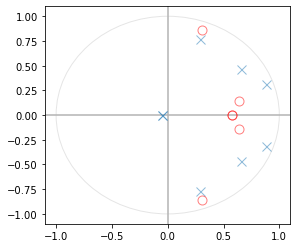

In [2]:
poles = tf.constant([(-0.05429768147702485+1.4172655611120915e-05j),
                     (0.2917622403739163+0.7731812636894612j),
                     (0.8768382244780407-0.31120458350060115j),
                     (0.6598943546882394-0.46728573398560225j)])
poles = tf.concat([poles, tf.math.conj(poles)], axis=0)
zeros = tf.constant([(0.635496172349615+0.14499945287904842j),
                     (0.30987058966944614-0.8574194617385421j),
                     (0.5721096307971768-2.2915816453724273e-05j)])
zeros = tf.concat([zeros, tf.math.conj(zeros)], axis=0)
pz_cell = pz.PZCell(tf.constant(1.34, dtype=tf.complex128),
                    poles,
                    zeros)
pz.plot_pz(pz_cell.poles, pz_cell.zeros).show()

### Ear frequency response

<img alt="Handbook of Sensory Physiology (Vol. 1), Keidel WD, Neff WD, eds., The external ear" style="height: 200px; float: right;" height="200"
src="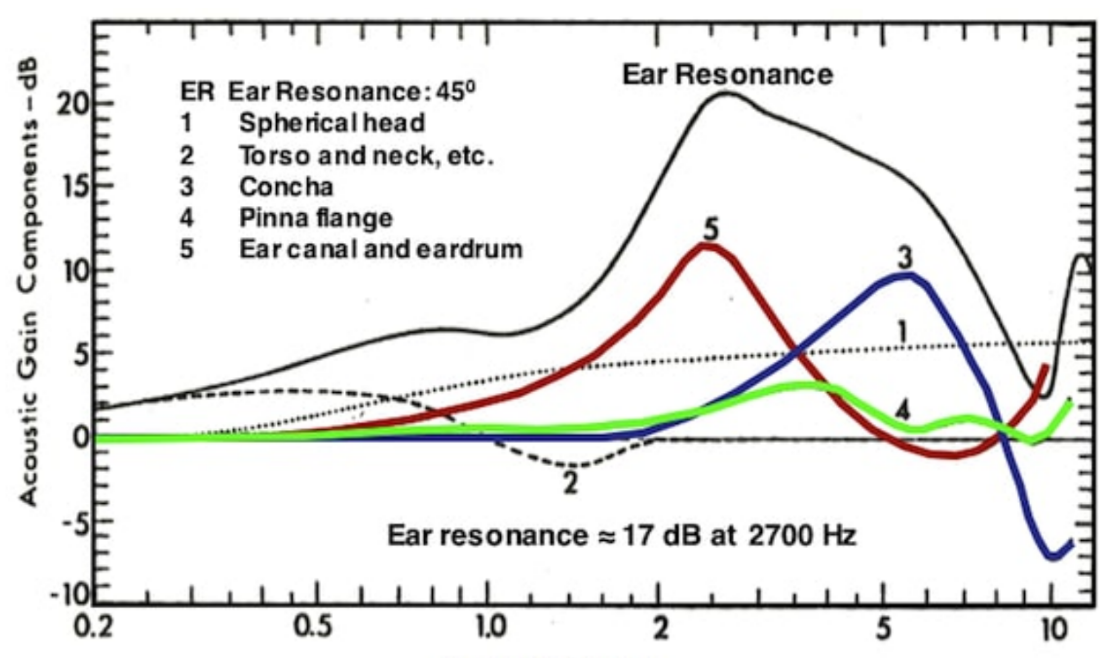" alt="The external ear. In : Keidel WD, Neff WD, eds. Handbook of Sensory Physiology (Vol. 1)">

As an example, this image ("Handbook of Sensory Physiology (Vol. 1), Keidel WD, Neff WD, eds., The external ear") represents the frequency response for some parts of the human ear

Using the `gain`, `poles`, and `zeros` for the `PZCell` defined above, we will get a filter matching the sum of plots 3, 4, and 5 in the above image:

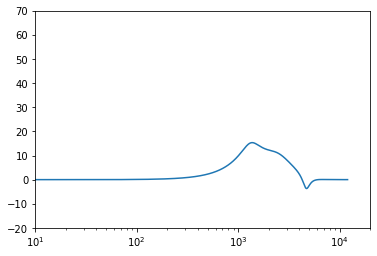

In [3]:
#@title {display-mode: "form"}
pz_layer = tf.keras.layers.RNN(pz_cell, return_sequences=True)
@tf.function
def call_pz_layer(arg):
  return pz_layer(arg)
impulse = np.zeros([1, 2048, 1], dtype=np.float64)
impulse[:, 0, :] = 1
pz.plot_z(np.fft.fft(call_pz_layer(impulse)[:, :, 0])).show()

## CARFAC

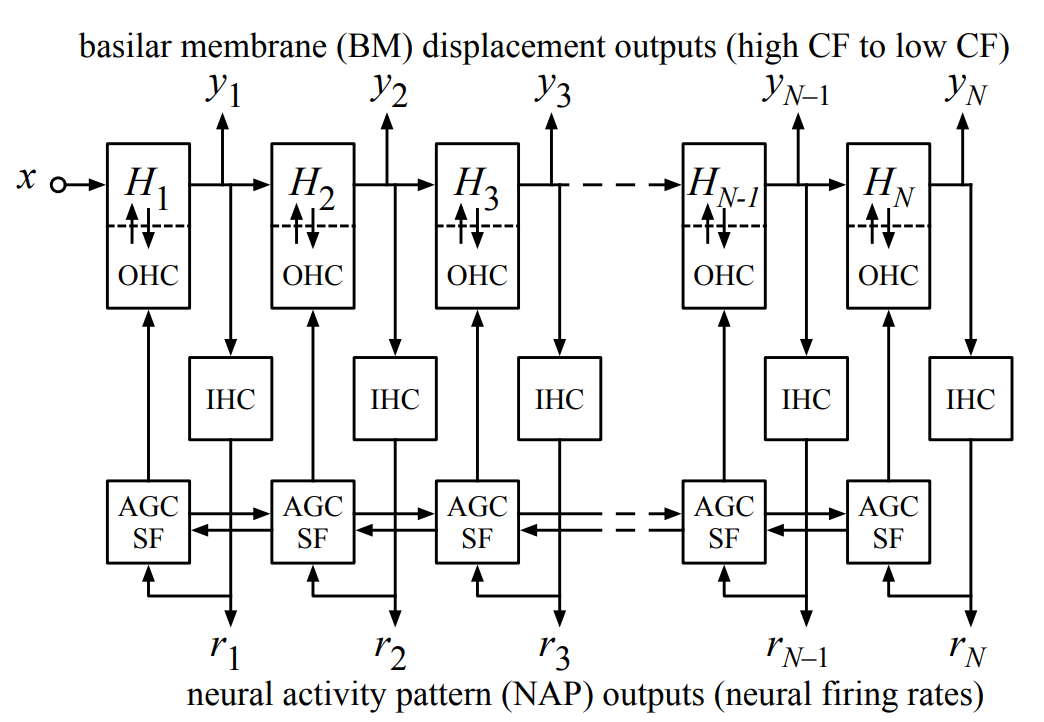

CARFAC (Cascade of Asymmetric Resonators with Fast Acting Compression) is a model of the human cochlea created by Dick Lyon.

It consists of a cascade of filters, where the input is fed through each filter in turn, and the output consists of the filter outputs as separate channels.

Each filter consists of a two-pole two-zero linear filter with added nonlinearities. The main parts are illustrated in this image ("Human and Machine Hearing, Dick Lyon, figure 15.2").

For more details see Human and Machine Hearing (http://dicklyon.com/hmh/) and the GitHub repository (https://github.com/google/carfac).

### CARFAC channels frequency response

#### CARFAC linear frequency respone

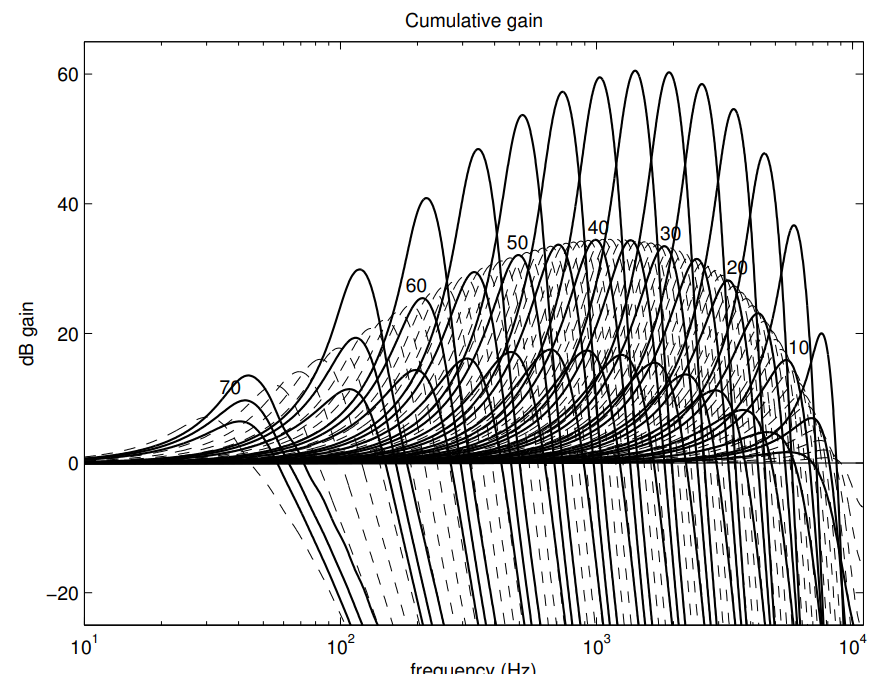

This image ("Human and Machine Hearing, Dick Lyon, figure 16.6") shows the cumulative frequency response of a cascade of CAR stages at a few different amplification levels.

Creating a `CARCell` with `linear=True` creates a cascade of those stages, and plotting their frequency response we will see a similar image.

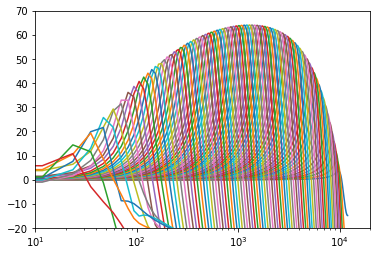

In [4]:
car.plot_car_channels(car.CARCell(linear=True, erb_per_step=0.5)).show()

#### CARFAC non-linear frequency response

Unfortunately there is no such plot to compare against with the non-linear CARCell, since it currently only implements a subset (the fast-acting compression) of the nonlinearities of the C++ and Matlab implementations.

However, since the fast-acting compression is expected to undampen for low levels, and dampen for high levels, one can assume that a flatter peak level across the channels (as shown below) is a sensible result:

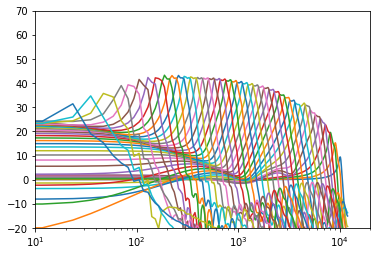

In [5]:
#@title {display-mode: "form"}
car.plot_car_channels(car.CARCell(linear=False, erb_per_step=1)).show()

Another thing to be aware of is that the nonlinearities don't have a lot of impact until you run the model with a minimum level of cochlear resolution, i.e. below a maximum level of `erb_per_step`.

Compare these plots of filters with `erb_per_step=2`:

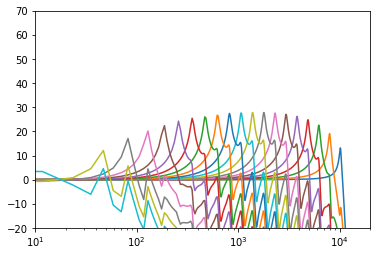

In [6]:
#@title `erb_per_step=2, linear=True` {display-mode: "form"}
car.plot_car_channels(car.CARCell(linear=True, erb_per_step=2)).show()

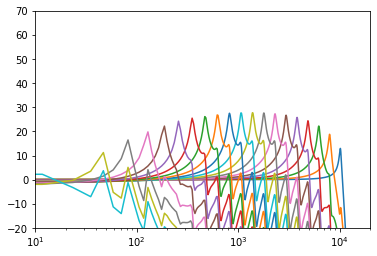

In [7]:
#@title `erb_per_step=2, linear=False` {display-mode: "form"}
car.plot_car_channels(car.CARCell(linear=False, erb_per_step=2)).show()

to these with `erb_per_step=1`:

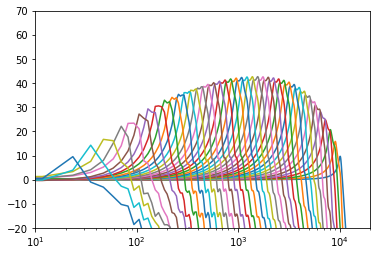

In [8]:
#@title `erb_per_step=1, Linear=True` {display-mode: "form"}
car.plot_car_channels(car.CARCell(linear=True, erb_per_step=1)).show()

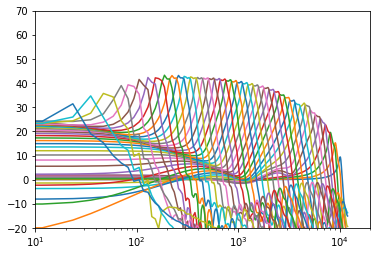

In [9]:
#@title `erb_per_step=1, Linear=False` {display-mode: "form"}
car.plot_car_channels(car.CARCell(linear=False, erb_per_step=1)).show()

### CARFAC parameters

Here are some plots to visualize the impact of the CARFAC parameters.

`erb_per_step` controls the distance between the filters, in terms of Equivalent Rectangular Bandwidth (a measure of human pitch sensitivity).

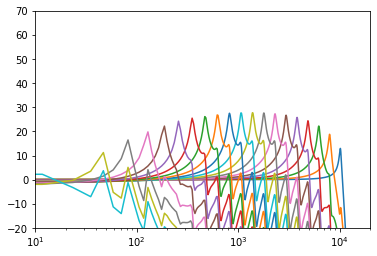

In [10]:
#@title erb_per_step = 2 {display-mode: "form"}
car.plot_car_channels(car.CARCell(linear=False, erb_per_step=2)).show()

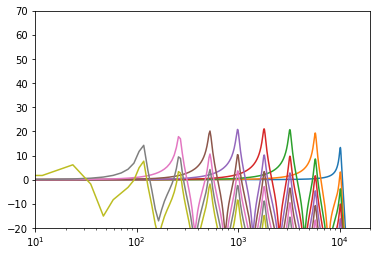

In [11]:
#@title erb_per_step = 4.0 {display-mode: "form"}
car.plot_car_channels(car.CARCell(linear=False, erb_per_step=4)).show()

`high_f_damping_compression` controls the distance between poles and zeros (which controls i.e. the slope on the right side of each channel filter) of the channel filters for high frequencies.

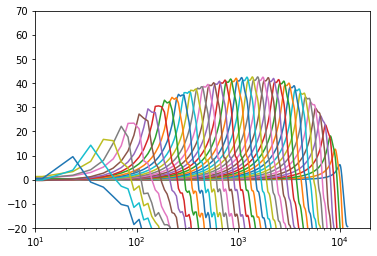

In [12]:
#@title high_f_damping_compression = 0.0 {display-mode: "form"}
car_cell = car.CARCell(linear=True, erb_per_step=1)
car_cell._high_f_damping_compression.assign(0.0)
car.plot_car_channels(car_cell).show()

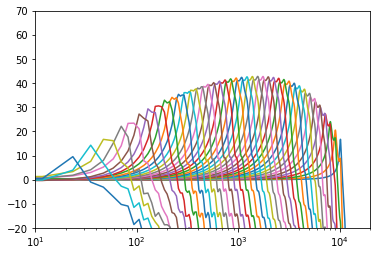

In [13]:
#@title high_f_damping_compression = 1.0 {display-mode: "form"}
car_cell = car.CARCell(linear=True, erb_per_step=1)
car_cell._high_f_damping_compression.assign(1.0)
car.plot_car_channels(car_cell).show()

`zero_ratio` controls the relative distance between poles and zeros (which controls i.e. the slope on the right side of each channel filter) across the entire spectrum.

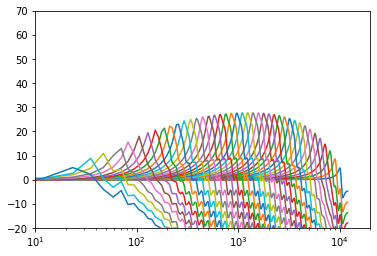

In [14]:
#@title zero_ratio = 1.2 {display-mode: "form"}
car_cell = car.CARCell(linear=True, erb_per_step=1)
car_cell._zero_ratio.assign(1.2)
car.plot_car_channels(car_cell).show()

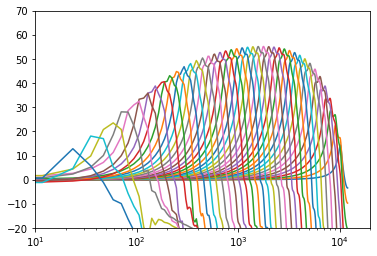

In [15]:
#@title zero_ratio = 1.7 {display-mode: "form"}
car_cell = car.CARCell(linear=True, erb_per_step=1)
car_cell._zero_ratio.assign(1.7)
car.plot_car_channels(car_cell).show()

`min_zeta` controls the minimum dampening of each channel gain, which controls gain for the entire output.

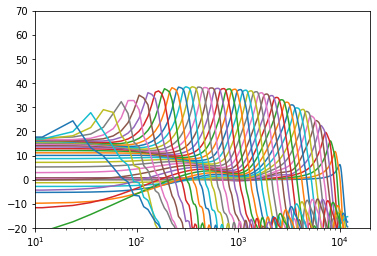

In [16]:
#@title min_zeta = 0.05 {display-mode: "form"}
car_cell = car.CARCell(erb_per_step=1)
car_cell._min_zeta.assign(0.05)
car.plot_car_channels(car_cell).show()

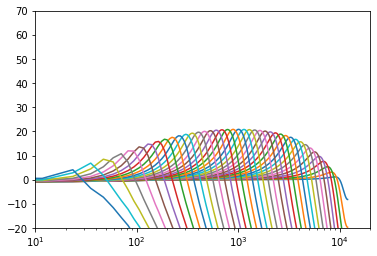

In [17]:
#@title min_zeta = 0.2 {display-mode: "form"}
car_cell = car.CARCell(erb_per_step=1)
car_cell._min_zeta.assign(0.2)
car.plot_car_channels(car_cell).show()

`max_zeta` controls maximum dampening of each channel gain, which controls gain for the entire output.

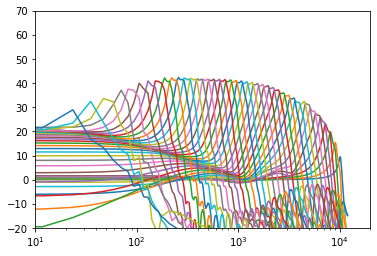

In [18]:
#@title max_zeta = 0.2 {display-mode: "form"}
car_cell = car.CARCell(erb_per_step=1)
car_cell._max_zeta.assign(0.2)
car.plot_car_channels(car_cell).show()

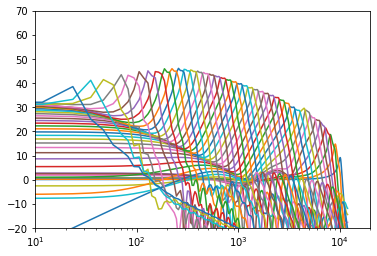

In [19]:
#@title max_zeta = 0.45 {display-mode: "form"}
car_cell = car.CARCell(erb_per_step=1)
car_cell._max_zeta.assign(0.45)
car.plot_car_channels(car_cell).show()